# Aprendizaje Multietiqueta de Patrones Geométricos en Objetos de Herencia Cultural
# Predictions testing
## Seminario de Tesis II, Primavera 2022
### Master of Data Science. Universidad de Chile.
#### Prof. guía: Benjamín Bustos - Prof. coguía: Iván Sipirán
#### Autor: Matías Vergara

El objetivo de este notebook es permitir testear predicciones realizadas mediante los notebooks de arquitecturas profundas (pytorch) con las celdas que usamos para los métodos tradicionales. Recibe un archivo de predicciones y un conjunto de flags.

In [1]:
# Mounting google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = 'drive/MyDrive/'
except:
    root_dir = '../'
    
import os
os.listdir(root_dir)

['.git',
 '.gitignore',
 '.idea',
 'actas',
 'entregables',
 'features',
 'graficos',
 'labels',
 'models',
 'notebooks',
 'outputs',
 'patterns',
 'presentaciones',
 'README.md',
 'requirements.txt',
 'tables']

# Dataset selection

In [2]:
#modify only this cell
DS_FLAGS = ['base']
              # 'ref': [invertX, invertY],
              # 'rot': [rotate90, rotate180, rotate270],
              # 'crop': [crop] * CROP_TIMES,
              # 'blur': [blur],
              # 'emboss': [emboss],
              # 'randaug': [randaug],
              # 'rain': [rain],
              # 'elastic': [elastic]
CROP_TIMES = 1
RANDOM_TIMES = 1
ELASTIC_TIMES = 1

use_pos_weights = False
pos_weights_factor = 2.5
labels_to_predict = 25
use_testval = True
model_name = 'alexnet'

In [3]:
# This cells builds the data_flags variable, that will be used
# to map the requested data treatment to folders
MAP_TIMES = {'crop': CROP_TIMES,
         'randaug': RANDOM_TIMES,
         'elastic': ELASTIC_TIMES,
}

DS_FLAGS = sorted(DS_FLAGS)
data_flags = '_'.join(DS_FLAGS) if len(DS_FLAGS) > 0 else 'base'
MULTIPLE_TRANSF = ['crop', 'randaug', 'elastic']
COPY_FLAGS = DS_FLAGS.copy()

for t in MULTIPLE_TRANSF:
    if t in DS_FLAGS:
        COPY_FLAGS.remove(t)
        COPY_FLAGS.append(t + str(MAP_TIMES[t]))
        data_flags = '_'.join(COPY_FLAGS)

labels_path = os.path.join(root_dir, 'labels', data_flags)

if not os.path.isdir(labels_path):
    raise FileNotFoundError("No existen directorios de datos para el conjunto de flags seleccionado. Verifique que el dataset exista en {}".format(
        (os.path.isdir(labels_path))))
print("Labels set encontrado en {}".format(labels_path))

exp_name = ''
str_pwf = str(pos_weights_factor).replace('.', '_')
exp_name += f'{labels_to_predict}L'
exp_name += '_testval' if use_testval else ''
exp_name += f'_weighted_{str_pwf}' if use_pos_weights else ''
print(f"Nombre del experimento a testear: {exp_name}")

output_dir = os.path.join(root_dir, 'outputs', 'alexnet', data_flags, exp_name)
pred_path = os.path.join(output_dir, 'predictions.csv')

if not os.path.isfile(pred_path):
    raise FileNotFoundError(f"No se encontró modelo en {pred_path}")
print(f"Las predicciones a evaluar son: {pred_path}")

Labels set encontrado en ../labels\base
Nombre del experimento a testear: 25L_testval
Las predicciones a evaluar son: ../outputs\alexnet\base\25L_testval\predictions.csv


In [4]:
train_filename = "augmented_train_df.json"
val_filename = "val_df.json"
test_filename = "test_df.json"

# Imports

In [21]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Data treatment
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,hamming_loss

# Plotting
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

# Selección de etiquetas

In [6]:
labels_train = pd.read_json(os.path.join(labels_path, train_filename), orient='index').sort_index()
labels_val = pd.read_json(os.path.join(labels_path, val_filename), orient='index').sort_index()
labels_test = pd.read_json(os.path.join(labels_path, test_filename), orient='index').sort_index()

In [7]:
labels_test_val = pd.DataFrame.append(labels_test, labels_val)
labels_test_val

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10b,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12b,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13h,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93g,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94a,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94c,0,0,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
96a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
def filter_labels(labels_df, freq=25, number_labels=None):
  """Filters a label dataframe based on labels frequency (number of events)

    Parameters:
    labels_df (DataFrame): dataframe of labels 
    freq (int): threshold frequency. Labels with a lower value will be filtered. 

    Returns:
    DataFrame: filtered labels dataframe

  """
  top_labels = None

  if not number_labels:
    filtered_df = labels_df.loc[:, labels_df.sum(axis=0) > freq]
    top_labels = filtered_df.sum().sort_values(ascending=False)
    return top_labels, 0

  if number_labels:
      filtered_labels = labels_df.shape[1]
      pivot = 0
      while filtered_labels > number_labels:
        #print(filtered_labels, number_labels, pivot)
        filtered_df = labels_df.loc[:, labels_df.sum(axis=0) > pivot]
        top_labels = filtered_df.sum().sort_values(ascending=False)
        filtered_labels = filtered_df.shape[1]
        pivot += 1
      print("Aplicando threshold {} para trabajar con {} labels".format(pivot, len(top_labels.values)))
      return top_labels, pivot


def filter_dfs(df, top_labels_df):
  df = df[df.columns.intersection(top_labels_df.index)]
  return df

def combine_dfs(labels_df, top_labels_df, features_df):
  """Combine labels dataframe with features dataframe based on index (patterns names)
     keeping only the most frequent labels.

    Parameters:
    labels_df (DataFrame): dataframe of labels, with patterns name as index
    top_labels_df (DataFrame): a 1D dataframe with the name of the most freq. labels, as 
    the outcome of filter_labels() function 
    features_df (DataFrame): dataframe of features, with patterns name as index 

    Returns:
    DataFrame: combined labels + features dataframe, merged on index

  """
  assert len(labels_df) == len(features_df)
  labels_df = labels_df[labels_df.columns.intersection(top_labels_df.index)]
  final_df = pd.merge(labels_df,       
                      features_df,  
                      left_index=True, right_index=True)
  return final_df

def split_data(final_df, top_labels_df, test_size):
  """Splits the data in train and test. 
    
    Parameters:
    final_df (DataFrame): outcome of combine_dfs.
    top_labels_df (DataFrame): dataframe of most freq. labels. Necessary to 
    know at which column the labels (Y) ends and the features (X) starts  
    freq (int): threshold frequency. Labels with a lower value will be filtered. 
    test_size (float): proportion test/(test+train).

    Returns:
    (np.array, np.array, np.array, np.array): X train, X test, Y train, Y test

  """
  X = np.array(final_df.iloc[:, len(final_df):], dtype=float)
  Y = np.array(final_df.iloc[:, 0:len(final_df)], dtype=float)
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,random_state=42)
  return X_train, X_test, Y_train, Y_test

In [9]:
top_labels_df, pivot = filter_labels(labels_train, number_labels = 25) # for example
top_labels_df

Aplicando threshold 26 para trabajar con 25 labels


panel            317
horizontal       254
vertical         121
hatched          120
ornament         114
lozenge           99
metopal           93
filling           84
triangle          69
double            69
cross-hatched     65
meander           57
chain             53
bar               48
outline           38
line              37
single            36
hook              36
dotted            36
zigzag            34
solid             31
turning           30
left              28
dot               27
right             27
dtype: int64

# Funciones auxiliares

In [10]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [11]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    """
    Prints confusion matrix for multilabel classification.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

def plot_multiple_matrix(cfs_matrix, present_labels, nrows=5, ncols=5, figsize=(6,10), filename="results"):
  """
  Plots multiple confusion matrix

  Parameters:
  cfs_matrix (2D array): an array containing the multiple confusion matrix as
                         outcome of multilabel_confusion_matrix()
  present_labels (1D array): array of strings with name of labels, in the same
                             order as they are in cfs_matrix
  nrows, ncols, figsize: number of rows, columns and size of the plot
  
  """
  fig, ax = plt.subplots(nrows, ncols, figsize=figsize)

  for axes, cfs_vals, label in zip(ax.flatten(), cfs_matrix, present_labels):
      print_confusion_matrix(cfs_vals, axes, label, ["N", "Y"])

  fig.tight_layout()
  plt.show()
  plt.savefig(filename + ".png")

# Carga de predicciones y evaluación

In [18]:
predictions = pd.read_csv(pred_path, index_col=0)
predictions = predictions.to_numpy()
NUM_LABELS = predictions.shape[1]

print(f"ATENCIÓN: El archivo de predicciones tiene {predictions.shape[1]} etiquetas, labels_to_predict: {labels_to_predict}")

ATENCIÓN: El archivo de predicciones tiene 25 etiquetas, labels_to_predict: 25


In [19]:
predictions.shape

(234, 25)

In [20]:
if NUM_LABELS > 0:
    # los top-labels deben sacarse en base al labels_train 
    top_labels, _= filter_labels(labels_train, number_labels = NUM_LABELS)
    print("ATTENTION: TESTING WITH {} LABELS".format(len(top_labels)))
    # y filtrarse desde el labels_test o test+val
    
    Y_test = filter_dfs(labels_test_val, top_labels)
    present_labels = top_labels.index
else:
    present_labels = labels_test_val.columns.values
    Y_test = labels_test

exact_match = accuracy_score(Y_test, predictions)
ham_loss = hamming_loss(Y_test, predictions)
ham_score = hamming_score(Y_test.values, predictions)
result = {"exact_match":exact_match,"hamming_loss": ham_loss, "hamming_score":ham_score}

cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test,
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)
print(ham_score)

Aplicando threshold 26 para trabajar con 25 labels
ATTENTION: TESTING WITH 25 LABELS
               precision    recall  f1-score   support

        panel       0.32      0.31      0.31        77
   horizontal       0.40      0.52      0.45        91
     vertical       0.13      0.32      0.18        19
      hatched       0.00      0.00      0.00         4
     ornament       0.00      0.00      0.00        12
      lozenge       0.15      0.08      0.10        26
      metopal       0.33      0.14      0.19        59
      filling       0.11      0.22      0.15        23
     triangle       0.00      0.00      0.00         0
       double       0.00      0.00      0.00         0
cross-hatched       0.17      0.26      0.21        34
      meander       0.05      0.17      0.08         6
        chain       0.00      0.00      0.00        21
          bar       0.07      0.08      0.07        13
      outline       0.00      0.00      0.00         0
         line       0.00      0.00

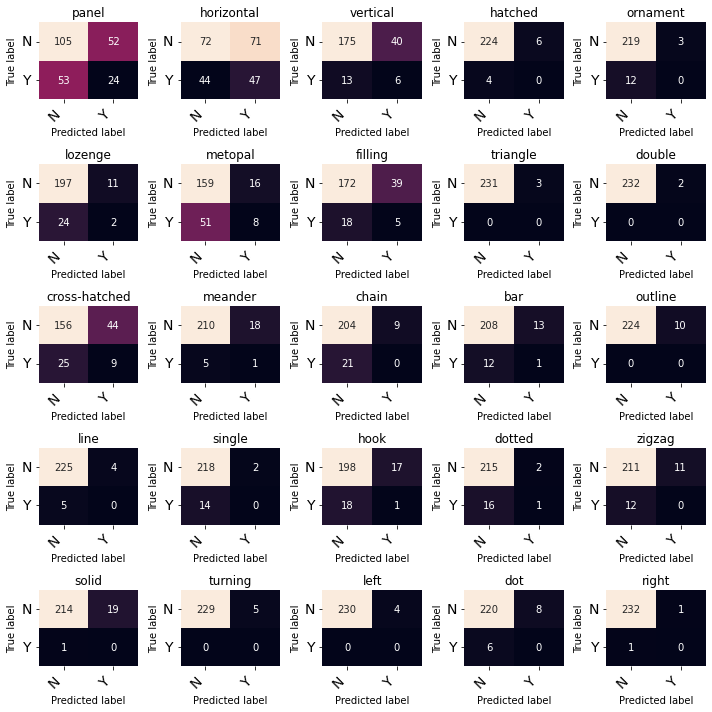

<Figure size 432x288 with 0 Axes>

In [16]:
# def plot_multiple_matrix(cfs_matrix, present_labels, nrows=5, ncols=5, figsize=(6,10), filename="results"):
plot_multiple_matrix(cfs_matrix, present_labels, figsize=(10, 10))